1, 4, 8 (7, 10 ec)

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

### 1

Draw an example (of your own invention) of a partition of two-
dimensional feature space that could result from recursive binary
splitting. Your example should contain at least six regions. Draw a
decision tree corresponding to this partition. Be sure to label all as-
pects of your figures, including the regions R1 , R2 , . . ., the cutpoints
t1 , t2 , . . ., and so forth.
Hint: Your result should look something like Figures 8.1 and 8.2.

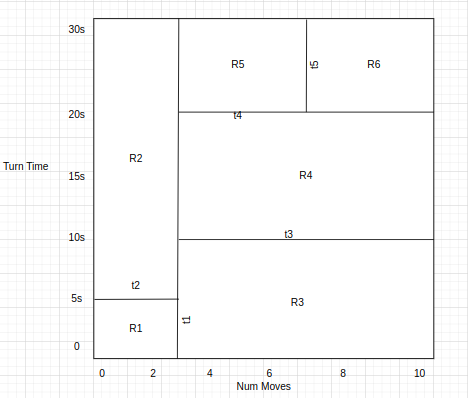
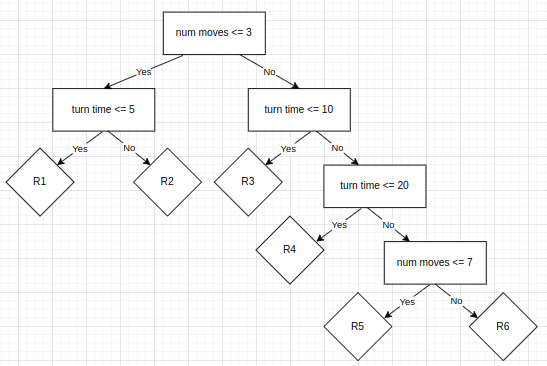

### 4

This question relates to the plots in Figure 8.14.

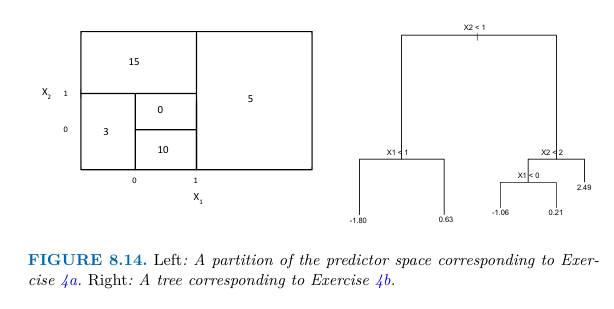

(a) Sketch the tree corresponding to the partition of the predictor space illustrated in the left-hand panel of Figure 8.14. The numbers inside the boxes indicate the mean of Y within each region.

(b) Create a diagram similar to the left-hand panel of Figure 8.14, using the tree illustrated in the right-hand panel of the same figure. You should divide up the predictor space into the correct regions, and indicate the mean for each region.

### 8

In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

In [2]:
Carseats = load_data('Carseats')

(a) Split the data set into a training set and a test set.

In [9]:
# train test split
X = Carseats.drop(columns='Sales')
y = Carseats['Sales']
# encode the qualitative variables
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.3)

(b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

Test MSE: 5.06797161085855


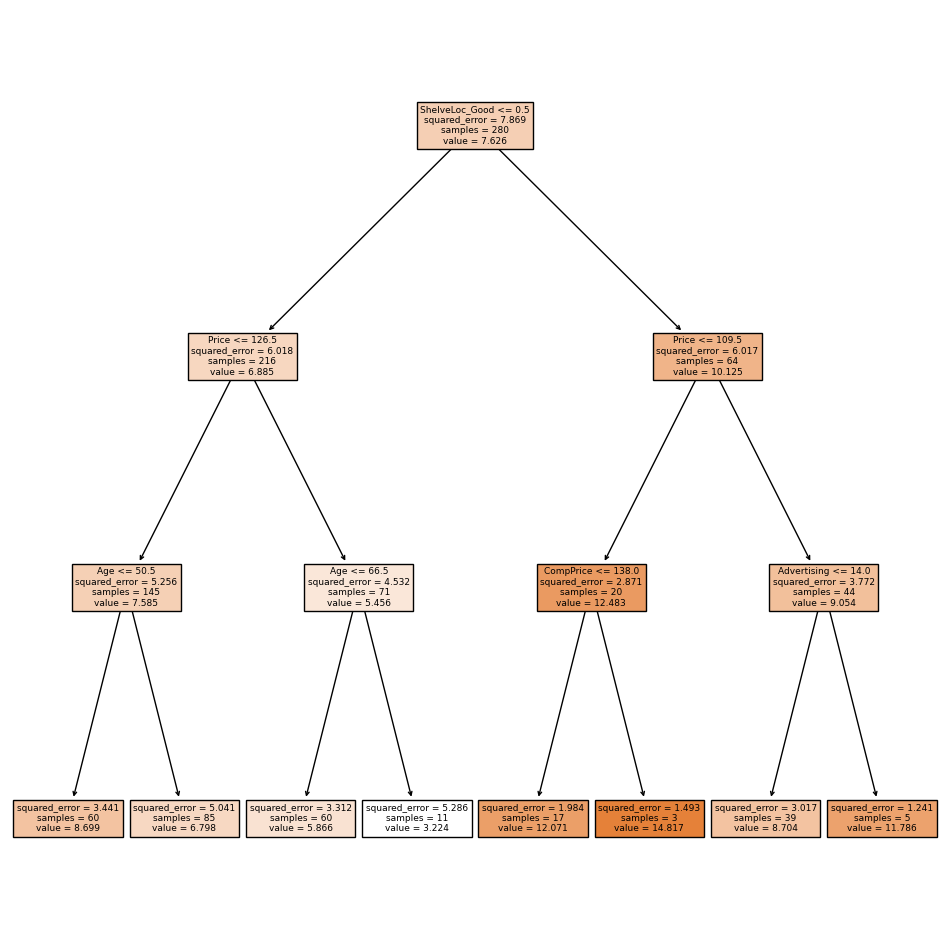

In [14]:
# Fit a regression tree
tree = DTR(criterion='squared_error', max_depth=3)
tree.fit(X_train, y_train)

# Plot the tree
_, ax = subplots(figsize=(12, 12))
plot_tree(tree, feature_names=X.columns, filled=True, ax=ax)

# Test MSE
y_pred = tree.predict(X_test)
test_mse = np.mean((y_test - y_pred)**2)
print(f'Test MSE: {test_mse}')

(c) Use cross-validation in order to determine the optimal level of
tree complexity. Does pruning the tree improve the test MSE?

In [17]:
# Cross-validation
param_grid = {'max_depth': np.arange(1, 10)}
cv = skm.GridSearchCV(tree, param_grid, cv=10, scoring='neg_mean_squared_error')
cv.fit(X, y)
cv_results = pd.DataFrame(cv.cv_results_)
# best results
best_depth = cv.best_params_['max_depth']
print(f'Best depth: {best_depth}')
# best model
best_tree = cv.best_estimator_
# Test MSE
y_pred = best_tree.predict(X_test)
test_mse = np.mean((y_test - y_pred)**2)
print(f'Test MSE: {test_mse}')

Best depth: 6
Test MSE: 1.1962368457361847


(d) Use the bagging approach in order to analyze this data. What
test MSE do you obtain? Use the feature_importance_ values to
determine which variables are most important.

In [18]:
# Bagging
bag = RF(n_estimators=500, max_features=X.shape[1])
bag.fit(X_train, y_train)
# Test MSE
y_pred = bag.predict(X_test)
test_mse = np.mean((y_test - y_pred)**2)
print(f'Test MSE: {test_mse}')
# Feature importance
importance = bag.feature_importances_
print(pd.Series(importance, index=X.columns).sort_values(ascending=False))

Test MSE: 2.3510804645066674
Price               0.290749
ShelveLoc_Good      0.235064
CompPrice           0.108666
Age                 0.102992
Advertising         0.082570
Income              0.055709
ShelveLoc_Medium    0.049709
Education           0.033100
Population          0.031307
Urban_Yes           0.005570
US_Yes              0.004564
dtype: float64


(e) Use random forests to analyze this data. What test MSE do
you obtain? Use the feature_importance_ values to determine
which variables are most important. Describe the effect of m, the
number of variables considered at each split, on the error rate
obtained.

In [19]:
# Random Forest
rf = RF(n_estimators=500, max_features='sqrt')
rf.fit(X_train, y_train)
# Test MSE
y_pred = rf.predict(X_test)
test_mse = np.mean((y_test - y_pred)**2)
print(f'Test MSE: {test_mse}')
# Feature importance
importance = rf.feature_importances_
print(pd.Series(importance, index=X.columns).sort_values(ascending=False))

Test MSE: 2.973280869223338
Price               0.233923
ShelveLoc_Good      0.171194
Age                 0.113678
CompPrice           0.098842
Income              0.092762
Advertising         0.090293
Population          0.070278
Education           0.062464
ShelveLoc_Medium    0.039487
US_Yes              0.014521
Urban_Yes           0.012557
dtype: float64


(f) Now analyze the data using BART, and report your results.

In [24]:
bart = BART(random_state=42, burnin=5, ndraw=15)
bart.fit(X_train, y_train)
# Test MSE
y_pred = bart.predict(X_test)
test_mse = np.mean((y_test - y_pred)**2)
print(f'Test MSE: {test_mse}')
# Feature importance
importance = bart.feature_importances_
print(pd.Series(importance, index=X.columns).sort_values(ascending=False))

ValueError: operands could not be broadcast together with shapes (120,) (11,) (120,) 

### 7

 In Section 8.3.3, we applied random forests to the Boston data using
max_features = 6 and using n_estimators = 100 and n_estimators =
500. Create a plot displaying the test error resulting from random
forests on this data set for a more comprehensive range of values
for max_features and n_estimators. You can model your plot after
Figure 8.10. Describe the results obtained.

In [19]:
Boston = load_data('Boston')
X = Boston.drop(columns='medv')
y = Boston['medv']
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.3)

# Grid search
param_grid = {'max_features': ['sqrt', len(X.columns)],
              'n_estimators': [100, 200, 300, 400, 500]}
cv = skm.GridSearchCV(RF(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
cv.fit(X, y)
cv_results = pd.DataFrame(cv.cv_results_)
# best results
best_params = cv.best_params_
print(f'Best params: {best_params}')
# best model
best_rf = cv.best_estimator_
# Test MSE
y_pred = best_rf.predict(X_test)
test_mse = np.mean((y_test - y_pred)**2)
print(f'Test MSE: {test_mse}')
# Feature importance
importance = best_rf.feature_importances_
print(pd.Series(importance, index=X.columns).sort_values(ascending=False))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'max_features': 12, 'n_estimators': 100}
Test MSE: 1.194283914473686
rm         0.455553
lstat      0.352331
dis        0.066946
crim       0.042450
nox        0.025334
ptratio    0.017172
tax        0.014844
age        0.013255
indus      0.006289
rad        0.003826
zn         0.001044
chas       0.000956
dtype: float64


/home/jake/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Text(0.5, 1.0, 'Test MSE as function of number of trees and number of features')

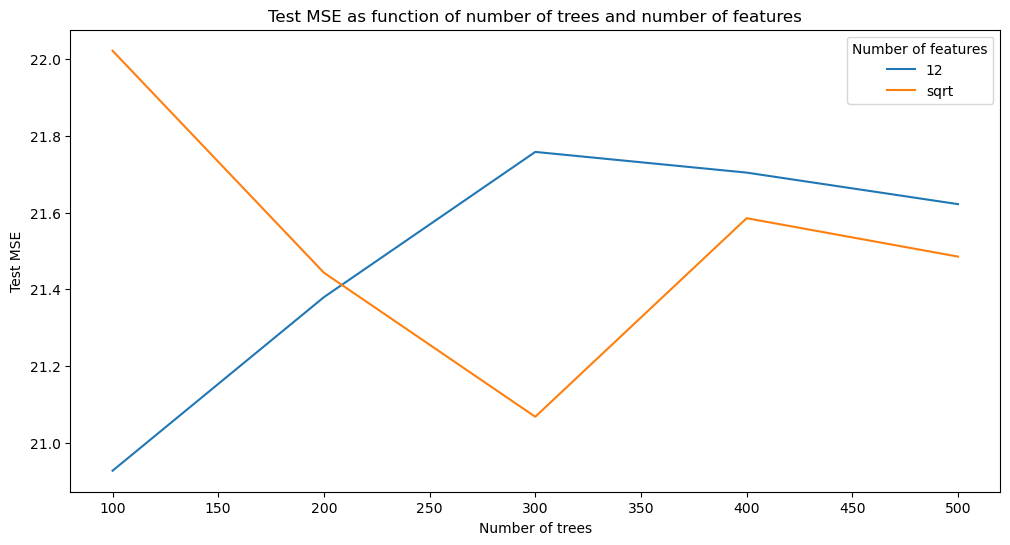

In [20]:
# plot test classfication error rate as function of number of trees and number of features (mse is neg so fix it)
cv_results['mean_test_score'] = -cv_results['mean_test_score']
_, ax = subplots(figsize=(12, 6))
for max_features, df in cv_results.groupby('param_max_features'):
    df.plot(x='param_n_estimators', y='mean_test_score', ax=ax, label=max_features)
ax.set_xlabel('Number of trees')
ax.set_ylabel('Test MSE')
ax.legend(title='Number of features')
ax.set_title('Test MSE as function of number of trees and number of features')

### 10

We now use boosting to predict Salary in the Hitters data set.

In [3]:
# hitters data
Hitters = load_data('Hitters')

(a) Remove the observations for whom the salary information is
unknown, and then log-transform the salaries.

In [4]:
# (a) Remove the observations for whom the salary information is
# unknown, and then log-transform the salaries.

Hitters = Hitters.dropna(subset=['Salary'])
Hitters['Salary'] = np.log(Hitters['Salary'])
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,6.163315,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,6.173786,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,6.214608,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,4.516339,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,6.620073,A


(b) Create a training set consisting of the first 200 observations, and
a test set consisting of the remaining observations.

In [7]:
X = Hitters.drop(columns=['Salary', 'League', 'Division', 'NewLeague'])
y = Hitters['Salary']
X_train, X_test = X.iloc[:200], X.iloc[200:]
y_train, y_test = y.iloc[:200], y.iloc[200:]

(c) Perform boosting on the training set with 1,000 trees for a range
of values of the shrinkage parameter λ. Produce a plot with
different shrinkage values on the x-axis and the corresponding
training set MSE on the y-axis.

Text(0.5, 1.0, 'Training MSE as function of shrinkage')

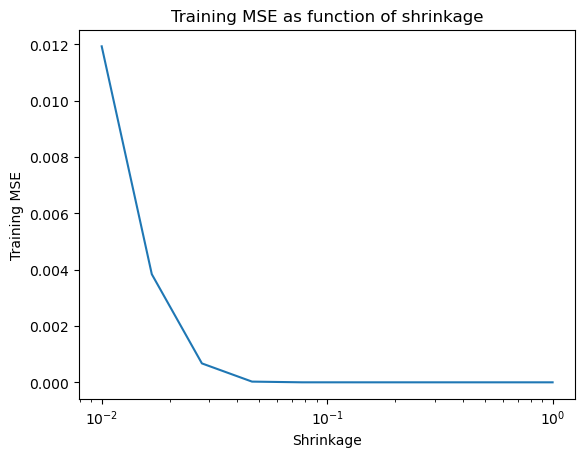

In [8]:
shrinkages = np.logspace(-2, 0, 10)
train_mses = []

for shrinkage in shrinkages:
    gbr = GBR(n_estimators=1000, learning_rate=shrinkage)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_train)
    mse = np.mean((y_train - y_pred)**2)
    train_mses.append(mse)

_, ax = subplots()
ax.plot(shrinkages, train_mses)
ax.set_xscale('log')
ax.set_xlabel('Shrinkage')
ax.set_ylabel('Training MSE')
ax.set_title('Training MSE as function of shrinkage')

(d) Produce a plot with different shrinkage values on the x-axis and
the corresponding test set MSE on the y-axis.

Text(0.5, 1.0, 'Test MSE as function of shrinkage')

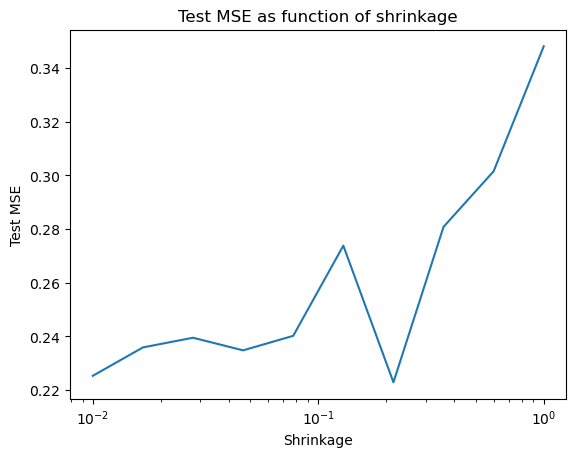

In [9]:
test_mses = []

for shrinkage in shrinkages:
    gbr = GBR(n_estimators=1000, learning_rate=shrinkage)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    mse = np.mean((y_test - y_pred)**2)
    test_mses.append(mse)

_, ax = subplots()
ax.plot(shrinkages, test_mses)
ax.set_xscale('log')
ax.set_xlabel('Shrinkage')
ax.set_ylabel('Test MSE')
ax.set_title('Test MSE as function of shrinkage')

(e) Compare the test MSE of boosting to the test MSE that results
from applying two of the regression approaches seen in
Chapters 3 and 6.

In [14]:
# Linear regression
from sklearn.linear_model import LinearRegression as LR
lr = LR()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse_linear = np.mean((y_test - y_pred)**2)

# Lasso
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse_lasso = np.mean((y_test - y_pred)**2)

# Boosting
gbr = GBR(n_estimators=1000, learning_rate=0.1)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
mse_boosting = np.mean((y_test - y_pred)**2)

resultsdf = pd.DataFrame({'Linear': mse_linear,
                            'Lasso': mse_lasso,
                            'Boosting': mse_boosting},
                             index=['MSE'])
print(resultsdf)

/home/jake/miniconda3/envs/mathenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.167e+01, tolerance: 1.664e-02
  model = cd_fast.enet_coordinate_descent(


       Linear     Lasso  Boosting
MSE  0.515697  0.513415  0.242715


(f) Which variables appear to be the most important predictors in
the boosted model?

In [15]:
# get boosted importance
importance = gbr.feature_importances_
print(pd.Series(importance, index=X.columns).sort_values(ascending=False))

CAtBat     0.544028
CHits      0.076588
CRuns      0.059740
AtBat      0.055252
Walks      0.042814
CRBI       0.040749
CHmRun     0.036045
Years      0.027138
Hits       0.025661
CWalks     0.024654
RBI        0.021526
PutOuts    0.015955
Runs       0.009167
Errors     0.007788
HmRun      0.007188
Assists    0.005705
dtype: float64


(g) Now apply bagging to the training set. What is the test set MSE
for this approach?

In [16]:
# (g) Now apply bagging to the training set. What is the test set MSE
# for this approach?

bag = RF(n_estimators=500, max_features=X.shape[1])
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)
mse_bagging = np.mean((y_test - y_pred)**2)
print(f'Bagging test MSE: {mse_bagging}')

Bagging test MSE: 0.23056189113303172
